In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gdrive_path = '/content/drive/MyDrive/thesis'

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, MultiHeadAttention, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import string
import re
import nltk
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.metrics import edit_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import pickle
import itertools
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [26]:
whole_data = pd.read_csv("Supervised_whole_data.csv")
train_data = pd.read_csv("supervised_train_data.csv")
test_data = pd.read_csv("supervised_test_data.csv")
unlabelled_data = pd.read_csv("unlabelled_data.csv")

In [7]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

NORMAL = 0
ABNORMAL = 1
CLASSIFICATION_THRESHOLDS = (0.4, 0.7)

KERAS_MODEL = "lstm_w2v_cbow.sav"
WORD2VEC_MODEL = "model.w2v_cbow"
TOKENIZER_MODEL = "w2v_tokenizer_cbow.pkl"
ENCODER_MODEL = "encoder_cbow.pkl"

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
# TEXT CLEANING
TEXT_CLEANING = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

def preprocess(text, stem=False):

    text = re.sub(TEXT_CLEANING, ' ', str(text).lower()).strip()
    tokens = []

    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)

    return " ".join(tokens)

In [27]:
whole_data.conclusion = whole_data.conclusion.apply(lambda x: preprocess(x))
train_data.conclusion = train_data.conclusion.apply(lambda x: preprocess(x))
test_data.conclusion = test_data.conclusion.apply(lambda x: preprocess(x))
unlabelled_data.conclusion = unlabelled_data.conclusion.apply(lambda x: preprocess(x))

In [21]:
whole_data.sample(10)

,conclusion,Abnormal
5190,temporal slow waves assuredly normal age eeg w...,0.0
3309,mildly abnormal eeg attenuated hz,1.0
5039,eeg revealed sleep related bilateral synchrono...,1.0
4476,eeg consistent generalised seizure disorder,1.0
6060,eeg within normal limits,0.0
3118,eeg showed excess beta activities consistent d...,1.0
4501,abnormal eeg absence background normal alpha r...,1.0
5354,multifocal slow spike wave hz one episode gene...,1.0
3825,eeg showed sharp sharp waves sometimes runs ve...,1.0
2575,abnormal eeg central sharp waves slow waves se...,1.0


In [22]:
X_train, y_train = train_data["conclusion"].values, train_data["Abnormal"].values
X_test, y_test = test_data["conclusion"].values, test_data["Abnormal"].values

In [28]:
unlabelled_data = unlabelled_data.loc[:, ~unlabelled_data.columns.str.contains('^Unnamed')]
frames = [whole_data, unlabelled_data]
data = pd.concat(frames)

In [29]:
data.sample(10)

,conclusion,Abnormal
5293,indication post stroke seizures r mca infarcti...,1.0
1926,normal eeg,NaN
3806,normal eeg,0.0
1390,eeg within normal limits,NaN
2866,eeg abnormal sharp waves temporal head areas i...,NaN
7020,diffuse cortical dysfunction,NaN
5632,eeg done discontinuation lignocaine infusion m...,NaN
3293,eeg within normal limits,NaN
1419,abnormal eeg recording episodes continous mout...,NaN
2648,normal eeg,NaN


In [30]:
documents = [_text.split() for _text in data.conclusion]
print(len(documents))

16350


In [31]:
cbow_w2v = gensim.models.Word2Vec(documents, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8, sg=0)

In [32]:
words = cbow_w2v.wv.index_to_key
vocab_size_wv = len(words)
print("Vocab size:", vocab_size_wv)

Vocab size: 858


In [33]:
cbow_w2v.wv.most_similar("abnormal")

[('intermittent', 0.891657292842865),
 ('slow', 0.7763570547103882),
 ('independent', 0.7464501857757568),
 ('predominantly', 0.7388375401496887),
 ('bifrontal', 0.7258828282356262),
 ('bilaterally', 0.7222976088523865),
 ('almost', 0.7201564311981201),
 ('continuous', 0.7189809679985046),
 ('irregular', 0.7170242667198181),
 ('mildly', 0.7161356806755066)]

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.conclusion)

In [35]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 4340


In [36]:
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

In [37]:
encoder = LabelEncoder()
encoder.fit(whole_data.Abnormal.tolist())
y_train = encoder.transform(y_train.tolist())
y_test = encoder.transform(y_test.tolist())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (5948, 1)
y_test (500, 1)


In [38]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (5948, 300)
y_train (5948, 1)

x_test (500, 300)
y_test (500, 1)


In [39]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
 if word in cbow_w2v.wv:
    embedding_matrix[i] = cbow_w2v.wv[word]
print(embedding_matrix.shape)

(4340, 300)


In [40]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [41]:
bilstm_model = Sequential()
bilstm_model.add(embedding_layer)
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
bilstm_model.add(Dense(1, activation='sigmoid', kernel_regularizer='l1'))
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          1302000   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 300, 100)          140400    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 300, 100)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 1

In [42]:
bilstm_model.compile(loss='binary_crossentropy',
                    optimizer="adam",
                    metrics=["accuracy"])

In [43]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [44]:
history = bilstm_model.fit(x_train, y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_split=0.1,
                         verbose=1,
                         callbacks=callbacks)

bilstm_model.save(KERAS_MODEL)
bilstm_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

Epoch 1/32
6/6 [==============================] - 39s 4s/step - loss: 0.7384 - accuracy: 0.7566 - val_loss: 0.5508 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 2/32
6/6 [==============================] - 23s 4s/step - loss: 0.4941 - accuracy: 0.9552 - val_loss: 0.3621 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 3/32
6/6 [==============================] - 23s 4s/step - loss: 0.3296 - accuracy: 0.9604 - val_loss: 0.2819 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 4/32
6/6 [==============================] - 22s 4s/step - loss: 0.2649 - accuracy: 0.9625 - val_loss: 0.2636 - val_accuracy: 0.9546 - lr: 0.0010
Epoch 5/32
6/6 [==============================] - 23s 4s/step - loss: 0.2401 - accuracy: 0.9654 - val_loss: 0.2643 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 6/32
6/6 [==============================] - 23s 4s/step - loss: 0.2278 - accuracy: 0.9658 - val_loss: 0.2647 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 7/32
6/6 [==============================] - 22s 4s/step - loss: 0.2184 - accuracy: 0.967

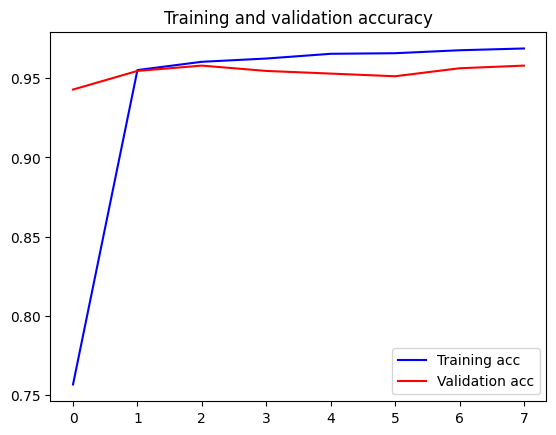

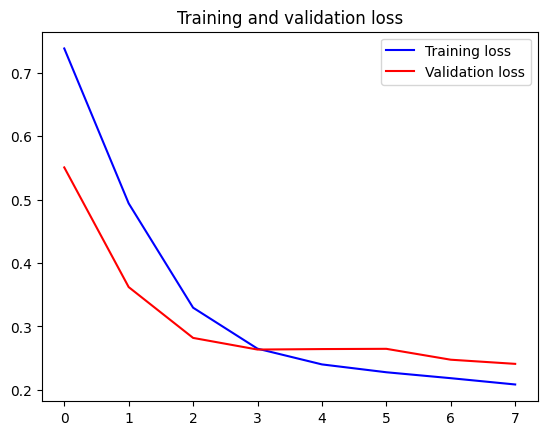

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
%%time
score = bilstm_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 360ms/step - loss: 0.2097 - accuracy: 0.9700

ACCURACY: 0.9700000286102295
LOSS: 0.20969167351722717
CPU times: user 404 ms, sys: 16.8 ms, total: 421 ms
Wall time: 697 ms


In [47]:
def decode_prediction(score):
  return NORMAL if score < 0.5 else ABNORMAL

In [48]:
%%time
y_pred_1d = []
y_test_1d = list(y_test)
scores = bilstm_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_prediction(score) for score in scores]

1/1 [==============================] - 1s 1s/step
CPU times: user 1.17 s, sys: 15.7 ms, total: 1.19 s
Wall time: 1.17 s


In [49]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize=30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
  plt.yticks(tick_marks, classes, fontsize=22)

  fmt = '.2f'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

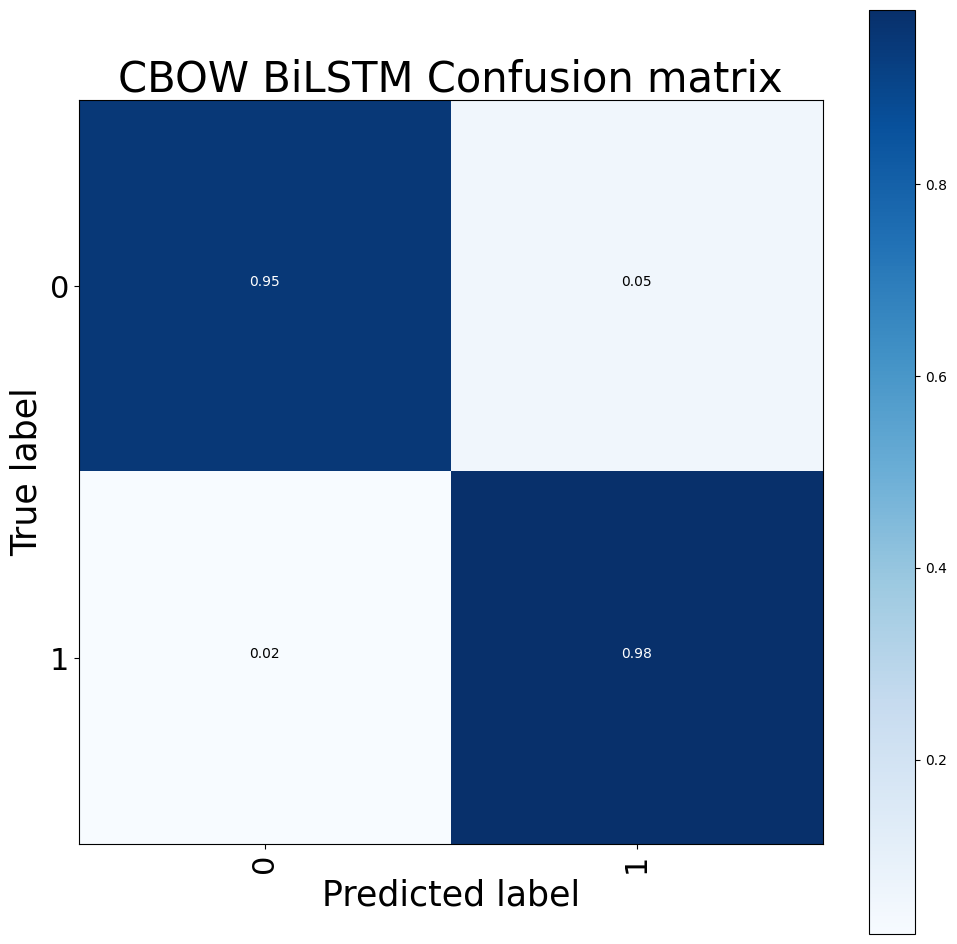

CPU times: user 343 ms, sys: 206 ms, total: 549 ms
Wall time: 324 ms


In [50]:
%%time
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(y_train), title="CBOW BiLSTM Confusion matrix")
plt.show()

In [51]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       176
           1       0.97      0.98      0.98       324

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500



In [52]:
accuracy_score(y_test_1d, y_pred_1d)

0.97

In [53]:
bilstm_model.save(f"{gdrive_path}{KERAS_MODEL}")
cbow_w2v.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)

In [ ]:
# download the trained model
import shutil
shutil.make_archive("/content/drive/MyDrive/thesis", 'zip', "/content/drive/MyDrive/thesis")
from google.colab import files
files.download("/content/drive/MyDrive/thesis.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
unlabelled_data = unlabelled_data.loc[:, ~unlabelled_data.columns.str.contains('^Unnamed')]
unlabelled_data = unlabelled_data.drop(columns=['Abnormal'])
unlabelled_data.head()

,conclusion
0,eeg showed generalised attenuation frontal slo...
1,eeg abnormal attenuated slow waves throughout ...
2,infrequent l anterior temporal sharp slow wave...
3,abnormal eeg sharp waves arising l temporal he...
4,eeg showed non specific sharp transients tempo...


In [56]:
unlabelled_data.dropna(inplace = True)

In [60]:
SEQUENCE_LENGTH = 300

def decode_classification(score):
  return 1 if score > 0.5 else 0

def batch_predict(texts):

  sequences = tokenizer.texts_to_sequences(texts)
  x_test = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH)

  # Predict using the entire batch
  scores = bilstm_model.predict(x_test, verbose=1, batch_size=8000)

  # Decode classification for the entire batch
  labels = [decode_classification(score) for score in scores]

  return labels

In [61]:
unlabelled_data['Abnormal'] = batch_predict(unlabelled_data["conclusion"].values)

2/2 [==============================] - 2s 510ms/step


In [62]:
unlabelled_data.to_csv('pseudo_labelled.csv')

In [63]:
pseudo_label = pd.read_csv('pseudo_labelled.csv')

In [64]:
pseudo_label = pseudo_label.loc[:, ~pseudo_label.columns.str.contains('^Unnamed')]
pseudo_label.head()

,conclusion,Abnormal
0,eeg showed generalised attenuation frontal slo...,1
1,eeg abnormal attenuated slow waves throughout ...,1
2,infrequent l anterior temporal sharp slow wave...,1
3,abnormal eeg sharp waves arising l temporal he...,1
4,eeg showed non specific sharp transients tempo...,0


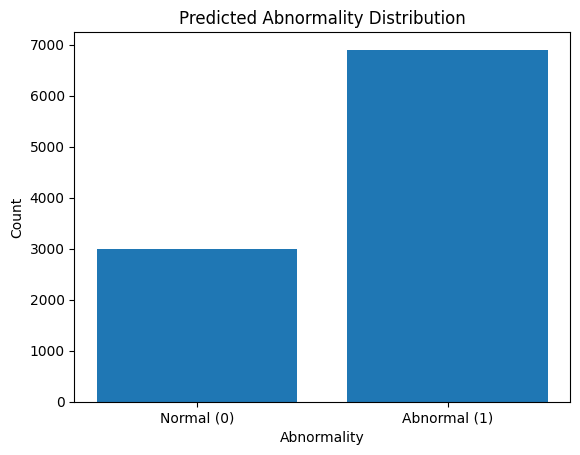

In [65]:
# visualize sentiment result distribution
sentiment_counts = pseudo_label['Abnormal'].value_counts()
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Predicted Abnormality Distribution")
plt.xlabel("Abnormality")
plt.ylabel("Count")
plt.xticks([0, 1], ["Normal (0)", "Abnormal (1)"])

# Show the plot
plt.show()